<a href="https://colab.research.google.com/github/Gabriel-Brenner/DataPUCPR1/blob/main/Exercise_L14_Design_of_experiments%2C_surrogate_models%2C_and_sensivity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Polynomial Regression MSE (Wine, 2 features): 0.35007432169364844
Polynomial Regression MSE (Iris, 2 features): 0.14631546585394328


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


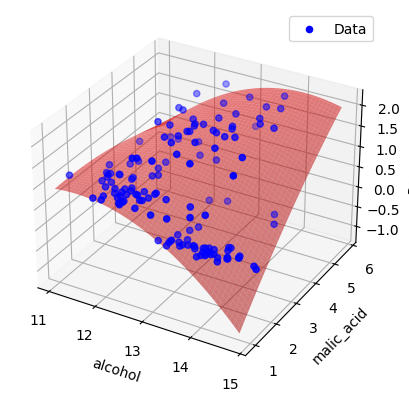

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


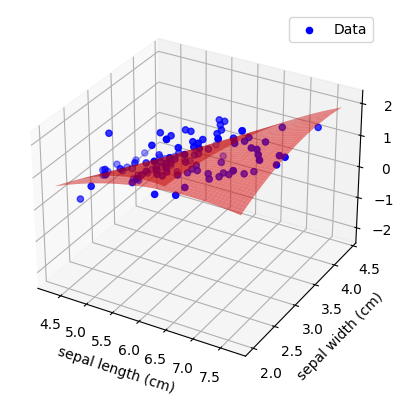

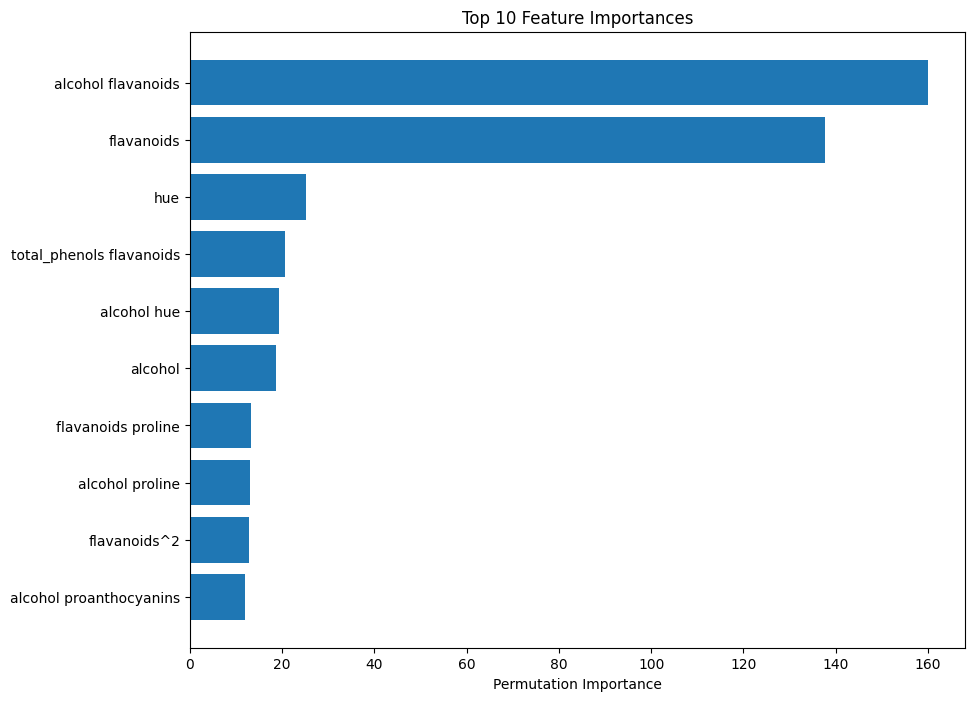

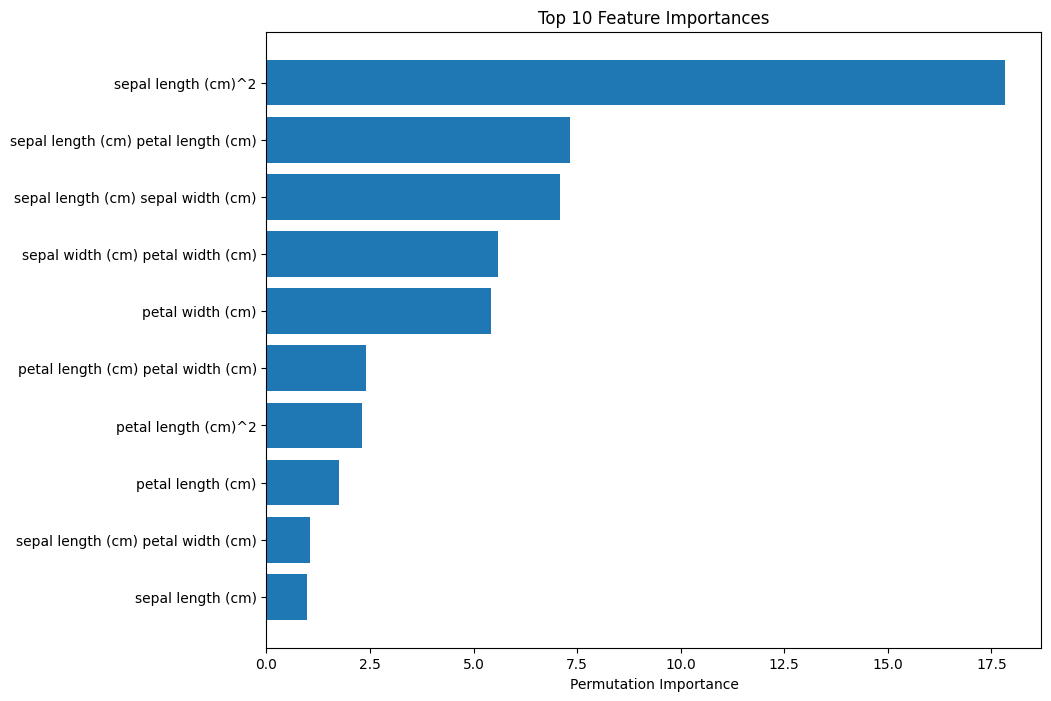

Full Factorial Design (Iris, 2 features, 3 levels):
[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]
 [2 0]
 [2 1]
 [2 2]]
Latin Hypercube Sampling (Iris, 10 samples, 2 features):
[[0.24743048 0.61685863]
 [0.89163094 0.02283529]
 [0.75332542 0.42876562]
 [0.31823198 0.85466358]
 [0.11824662 0.93335169]
 [0.4536462  0.23006666]
 [0.56869266 0.14265597]
 [0.91572279 0.58701914]
 [0.03106151 0.3004097 ]
 [0.65778447 0.76868357]]


In [ ]:
# Install necessary libraries
!pip install pyDOE2

# Import libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine, load_iris
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyDOE2 import lhs

# Load datasets
wine_data = load_wine()
iris_data = load_iris()

wine_df = pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
wine_df['target'] = wine_data.target

iris_df = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris_df['target'] = iris_data.target

# Helper function to prepare data
def prepare_data(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Prepare data for wine and iris datasets using all features
wine_X_train, wine_X_test, wine_y_train, wine_y_test = prepare_data(wine_df, 'target')
iris_X_train, iris_X_test, iris_y_train, iris_y_test = prepare_data(iris_df, 'target')

# Polynomial Regression for two features (for visualization purposes)
def polynomial_regression_two_features(X_train, X_test, y_train, y_test, degree=2):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred = model.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)
    return model, mse, poly

# Prepare data for wine and iris datasets using only the first two features for visualization
wine_X_train_2 = wine_X_train.iloc[:, :2]
wine_X_test_2 = wine_X_test.iloc[:, :2]
iris_X_train_2 = iris_X_train.iloc[:, :2]
iris_X_test_2 = iris_X_test.iloc[:, :2]

# Apply Polynomial Regression for two features
wine_poly_model_2, wine_poly_mse_2, wine_poly_transformer_2 = polynomial_regression_two_features(wine_X_train_2, wine_X_test_2, wine_y_train, wine_y_test)
iris_poly_model_2, iris_poly_mse_2, iris_poly_transformer_2 = polynomial_regression_two_features(iris_X_train_2, iris_X_test_2, iris_y_train, iris_y_test)

# Display results for two features
print("Polynomial Regression MSE (Wine, 2 features):", wine_poly_mse_2)
print("Polynomial Regression MSE (Iris, 2 features):", iris_poly_mse_2)

# Function to plot 3D response surface for polynomial regression with two features
def plot_response_surface_poly_two_features(model, poly_transformer, X, y, feature_names):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], y, color='b', label='Data')
    X1, X2 = np.meshgrid(np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), 100),
                         np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), 100))
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    X_grid_poly = poly_transformer.transform(X_grid)
    y_pred = model.predict(X_grid_poly)
    ax.plot_surface(X1, X2, y_pred.reshape(X1.shape), color='r', alpha=0.5)

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel('Response')
    ax.legend()
    plt.show()

# Plot response surface for wine dataset (using the first two features for simplicity)
plot_response_surface_poly_two_features(wine_poly_model_2, wine_poly_transformer_2, wine_X_train_2, wine_y_train, wine_df.columns[:2])
# Plot response surface for iris dataset (using the first two features for simplicity)
plot_response_surface_poly_two_features(iris_poly_model_2, iris_poly_transformer_2, iris_X_train_2, iris_y_train, iris_df.columns[:2])

# Polynomial Regression for all features
def polynomial_regression(X_train, X_test, y_train, y_test, degree=2):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred = model.predict(X_test_poly)
    mse = mean_squared_error(y_test, y_pred)
    return model, mse, poly

# Apply Polynomial Regression for all features
wine_poly_model, wine_poly_mse, wine_poly_transformer = polynomial_regression(wine_X_train, wine_X_test, wine_y_train, wine_y_test, degree=2)
iris_poly_model, iris_poly_mse, iris_poly_transformer = polynomial_regression(iris_X_train, iris_X_test, iris_y_train, iris_y_test, degree=2)

# Sensitivity analysis using permutation importance
def sensitivity_analysis(model, X, y, poly_transformer, top_n=10):
    X_poly = poly_transformer.transform(X)
    results = permutation_importance(model, X_poly, y, n_repeats=10, random_state=42)
    importance = results.importances_mean
    feature_names = poly_transformer.get_feature_names_out(input_features=X.columns)
    sorted_idx = importance.argsort()[-top_n:]  # Select top_n features
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_idx)), importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.title(f"Top {top_n} Feature Importances")
    plt.show()

# Sensitivity analysis for wine dataset using all features
sensitivity_analysis(wine_poly_model, wine_X_test, wine_y_test, wine_poly_transformer, top_n=10)
# Sensitivity analysis for iris dataset using all features
sensitivity_analysis(iris_poly_model, iris_X_test, iris_y_test, iris_poly_transformer, top_n=10)

# Full Factorial Design
def full_factorial_design(levels):
    from itertools import product
    return np.array(list(product(*[range(l) for l in levels])))

# Latin Hypercube Sampling
def latin_hypercube_sampling(n_samples, n_features):
    return lhs(n_features, samples=n_samples)

# Applying Full Factorial Design to Iris dataset with two features and 3 levels
iris_ffd = full_factorial_design([3, 3])
print("Full Factorial Design (Iris, 2 features, 3 levels):")
print(iris_ffd)

# Applying Latin Hypercube Sampling to Iris dataset with two features
iris_lhs = latin_hypercube_sampling(10, 2)
print("Latin Hypercube Sampling (Iris, 10 samples, 2 features):")
print(iris_lhs)
